In [457]:
import pyqg
import pyqg_generative.tools.operators as op
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pyqg_parameterization_benchmarks.coarsening_ops as ppb
from pyqg_generative.tools.spectral_tools import *
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [458]:
def error(x,y):
    return float(np.mean(np.abs(x-y)))

In [459]:
X = np.random.randn(64,64)
Y = np.ones((64,64))
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc').isel(run=0,time=-1,lev=0).q.values.astype('float64')

ratio=2, error=0.12311981310071998
ratio=10, error=0.0021653880761882344
ratio=20, error=0.001031567500567219
ratio=30, error=0.0008829639927336872


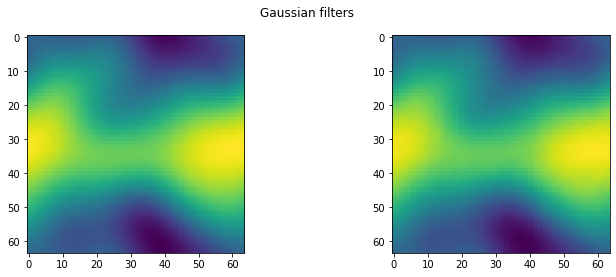

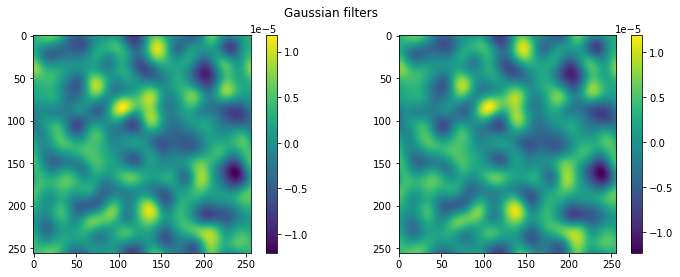

In [460]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(X, 30))
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(X, 30))
plt.suptitle('Gaussian filters')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(q, 30)); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(q, 30)); plt.colorbar()
plt.suptitle('Gaussian filters')

for ratio in [2, 10, 20, 30]:
    print(f'ratio={ratio}, error={error(op.gauss_filter(X, ratio), op.gcm_filter(X, ratio))}')

Text(0.5, 0.98, 'Model filter')

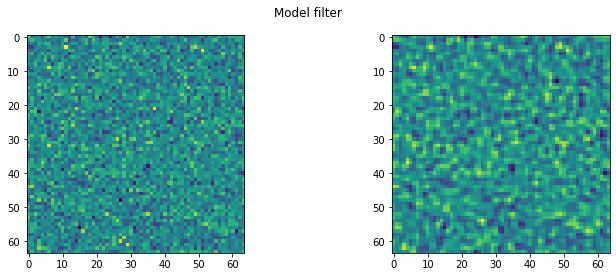

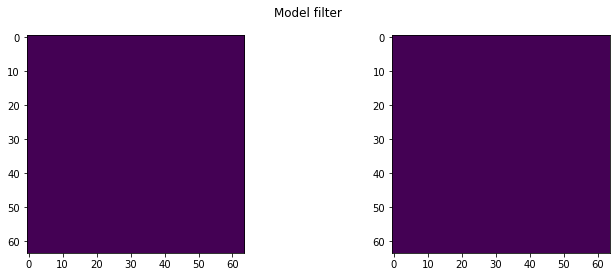

In [461]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(X)
plt.subplot(1,2,2); plt.imshow(op.model_filter(X))
plt.suptitle('Model filter')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(Y)
plt.subplot(1,2,2); plt.imshow(op.model_filter(Y))
plt.suptitle('Model filter')

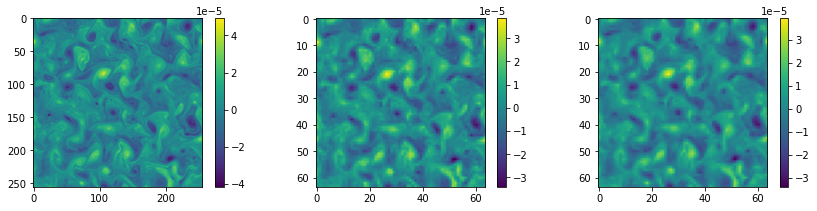

In [462]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(q); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(op.cut_off(q,4)); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(op.coarsegrain(q,4)); plt.colorbar()
plt.tight_layout()

# Commutation errors

In [463]:
error(op.gauss_filter(op.cut_off(X, 4), 2), op.cut_off(op.gauss_filter(X, 8), 4)) / np.mean(np.abs(X))

4.3065041234689364e-17

In [464]:
error(op.gcm_filter(op.coarsegrain(X, 4), 2), op.coarsegrain(op.gcm_filter(X, 8), 4)) / np.mean(np.abs(X))

0.06581702235123464

In [465]:
error(op.gcm_filter(op.gauss_filter(X, 3), 3), op.gauss_filter(op.gcm_filter(X, 3), 3)) / np.mean(np.abs(X))

9.114421838273442e-17

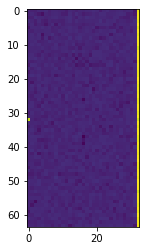

In [466]:
plt.imshow(np.log(np.abs(np.fft.rfftn(op.clean_2h(X)-X))))

# Try different formats

In [467]:
ds = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc')

In [468]:
op1 = op.gauss_filter

In [469]:
op1(np.stack((X,X)), ratio=4)[0]

array([[ 0.46001106,  0.33285767,  0.16981646, ...,  0.33294648,
         0.44181864,  0.49515319],
       [ 0.18473286,  0.13755456,  0.08477358, ...,  0.18909586,
         0.2725078 ,  0.24745465],
       [-0.34308696, -0.34392199, -0.19984036, ..., -0.1052806 ,
        -0.03895718, -0.16106242],
       ...,
       [ 0.20646211,  0.17095905,  0.24448123, ..., -0.14985192,
         0.0030173 ,  0.15011781],
       [ 0.27444576,  0.23940469,  0.322112  , ..., -0.05737612,
         0.11985825,  0.25835951],
       [ 0.38714406,  0.28790863,  0.2262969 , ...,  0.15135574,
         0.30211173,  0.40918198]])

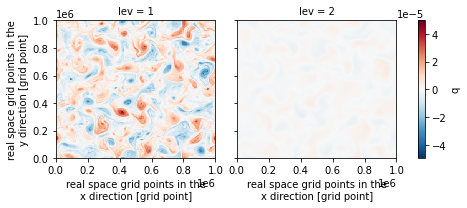

In [470]:
op.model_filter(ds.q.isel(run=0,time=-1), 2).plot(col='lev')


# Operators

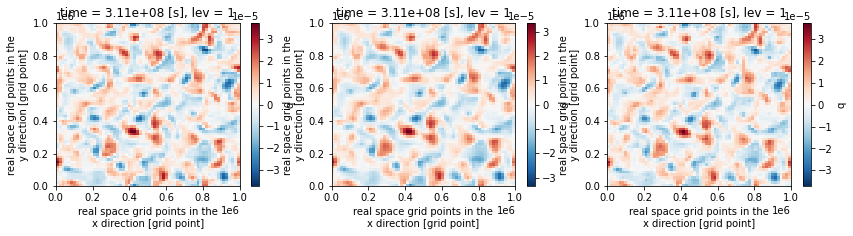

In [471]:
q = ds.q.isel(run=0, time=-1,lev=0)
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
op.Operator1(q, 4).plot()
plt.subplot(1,3,2)
op.Operator2(q, 4).plot()
plt.subplot(1,3,3)
op.Operator3(q, 4).plot()

# Comparison of operators to Andrew ones. Note the error only due to removing 2h harmonics!

In [472]:
m = pyqg.QGModel(nx=256, log_level=0)
q = ds.q.isel(run=0, time=-1).astype('float64')
q = q - q.mean(('x','y'))
m.q = q.values

In [498]:
def plot_error(Andrew, Me, qf, labels=('Andrew', 'Me')):
    print(f'mean Andrew = {float(Andrew.mean())}, mean Me = {float(Me.mean())}')
    plt.figure(figsize=(16,3))
    plt.subplot(1,5,1)
    plt.imshow(Andrew); plt.colorbar(); plt.title(labels[0])
    plt.subplot(1,5,2)
    plt.imshow(Me); plt.colorbar(); plt.title(labels[1])
    err = Andrew-Me
    plt.subplot(1,5,3)
    plt.imshow(err); plt.colorbar(); plt.title('Difference')
    plt.subplot(1,5,4)
    plt.imshow(np.abs(np.fft.rfftn(err)))
    plt.title('Spectrum of error')
    plt.subplot(1,5,5)
    _m = pyqg.QGModel(nx=Andrew.shape[0])
    error_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(err))), averaging=False, truncate=False)
    Andrew_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(Andrew))), averaging=False, truncate=False)
    Me_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(Me))), averaging=False, truncate=False)
    plt.semilogx(error_spec[0], np.abs(error_spec[1]), label='Error')
    plt.semilogx(Andrew_spec[0], np.abs(Andrew_spec[1]), label=labels[0], color='y')
    plt.semilogx(Me_spec[0], np.abs(Me_spec[1]), label=labels[1], ls='--', color='k')
    plt.legend()
    plt.title('Cospectrum of error')
    return err

def plot_operators(opAndrew, opMe):
    Andrew = opAndrew(m, 64).m2.q[1]
    Me = opMe(q, 4)[1]
    qf = op.Operator3(q, 4)[1]
    return plot_error(Andrew, Me, qf)

INFO:  Logger initialized


mean Andrew = 2.6469779601696886e-23, mean Me = 2.6469779601696886e-23


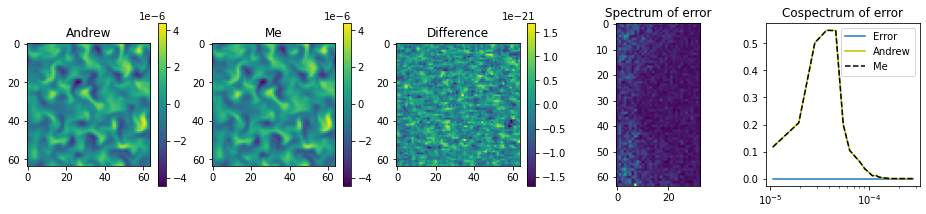

In [499]:
err1 = plot_operators(ppb.Operator1, op.Operator1);

INFO:  Logger initialized


mean Andrew = 1.9852334701272664e-23, mean Me = 2.6469779601696886e-23


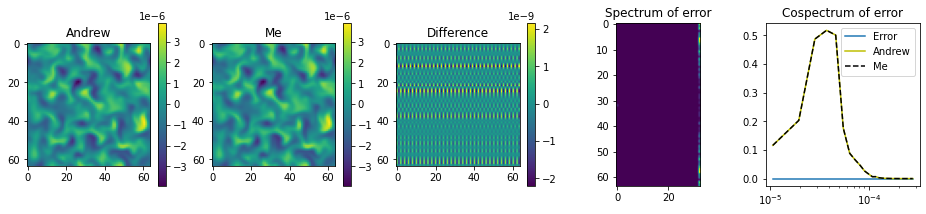

In [500]:
err2 = plot_operators(ppb.Operator2, op.Operator2);

INFO:  Logger initialized


mean Andrew = 3.3087224502121107e-23, mean Me = 3.970466940254533e-23


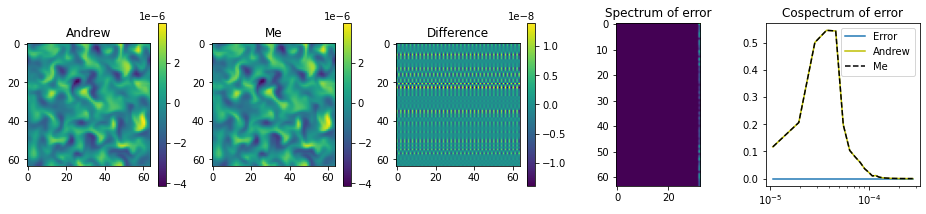

In [476]:
err3 = plot_operators(ppb.Operator3, op.Operator3)

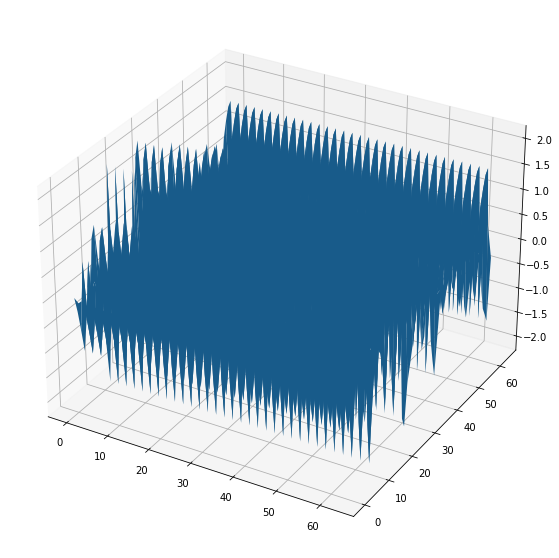

In [477]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(*np.meshgrid(range(64),range(64)), err2)

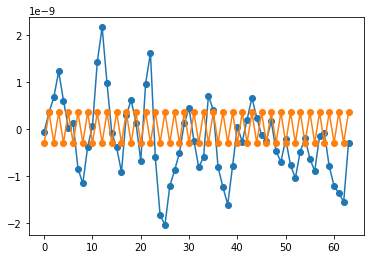

In [478]:
plt.plot(err2[:,1], marker='o')
plt.plot(err2[1,:], marker='o')

# Computation of subgrid flux

In [483]:
def plot_fluxes(opAndrew, opMe):
    Andrew = -opAndrew(m, 64).subgrid_fluxes('q')[0][0]
    Me = op.PV_subgrid_flux(q.values, 4, opMe, {})[0][0]
    qf = op.Operator1(q, 4)[0]
    return plot_error(Andrew, Me, qf)

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


mean Andrew = -2.759081150731415e-14, mean Me = -2.759081151537916e-14


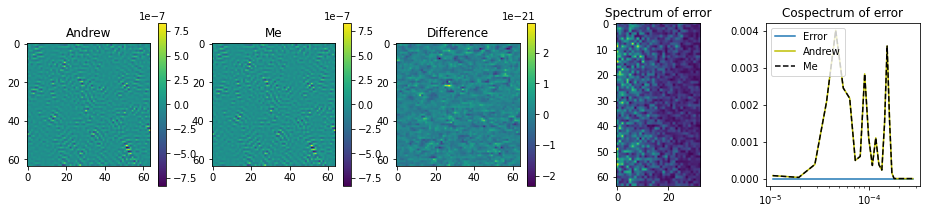

In [484]:
err1 = plot_fluxes(ppb.Operator1, op.Operator1)

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


mean Andrew = 4.0303533705237116e-10, mean Me = 4.030354072637068e-10


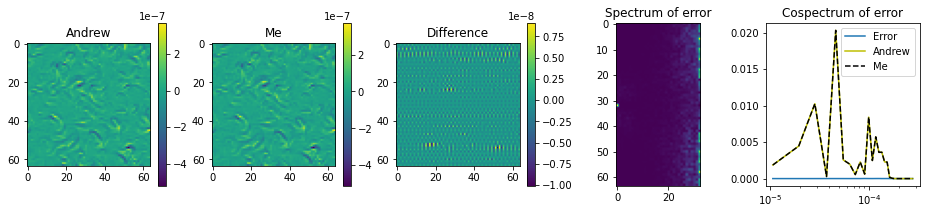

In [485]:
err2 = plot_fluxes(ppb.Operator2, op.Operator2)

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


mean Andrew = 2.062693068280235e-10, mean Me = 2.0628814895495195e-10


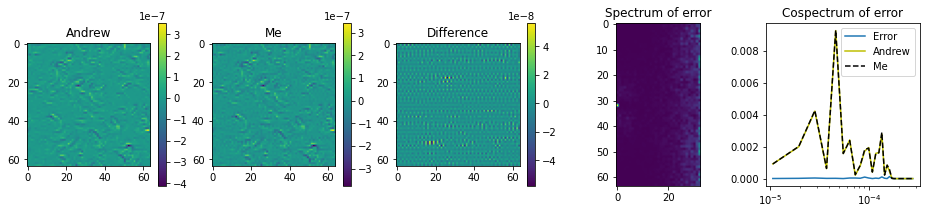

In [486]:
err3 = plot_fluxes(ppb.Operator3, op.Operator3)

# Computation of subgrid forcing

In [492]:
def plot_forces(opAndrew, opMe):
    Andrew = -opAndrew(m, 64).subgrid_forcing('q')[0]
    Me = op.PV_subgrid_forcing(q.values, 4, opMe, {})[0]
    qf = op.Operator3(q, 4)[0]
    return plot_error(Andrew, Me, qf)

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


mean Andrew = -2.9187853493177437e-29, mean Me = -9.308558681607939e-29


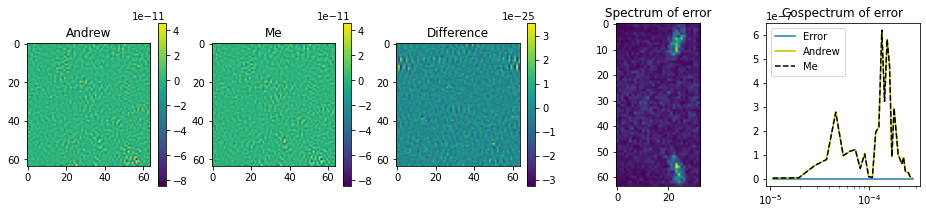

In [493]:
err1 = plot_forces(ppb.Operator1, op.Operator1)

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


mean Andrew = 8.67746995743113e-30, mean Me = -3.2343297114061484e-29


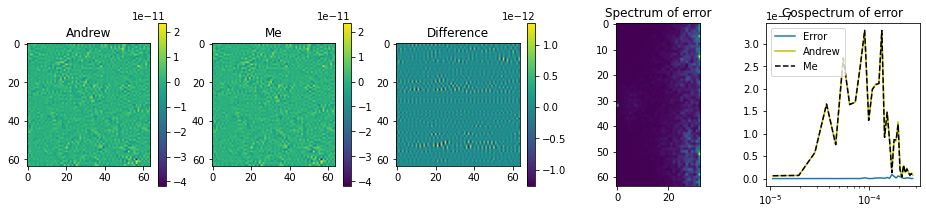

In [494]:
err2 = plot_forces(ppb.Operator2, op.Operator2)

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


mean Andrew = -1.139904008044362e-28, mean Me = 1.8143800820083272e-29


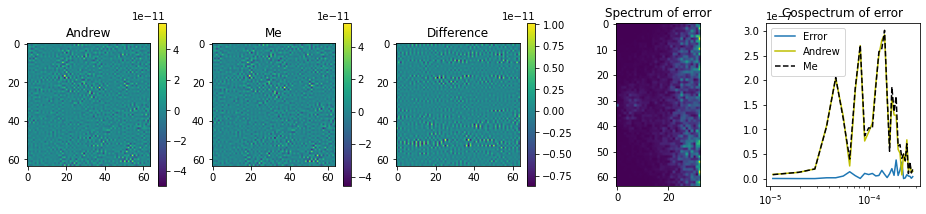

In [497]:
err3 = plot_forces(ppb.Operator3, op.Operator3)

# Commutation errors between subgrid and subfilter fluxes

In [509]:
def plot_commutation(opAndrew, opMe):
    qf = op.Operator3(q, 4)[0]
    
    forcing = -opAndrew(m, 64).subgrid_forcing('q')[0]
    flux = - op.divergence(*opAndrew(m, 64).subgrid_fluxes('q'))[0]
    plot_error(forcing, flux, qf, labels=('forcing', 'flux'))
    plt.suptitle('Andrew code', y=1.05)
    
    forcing = op.PV_subgrid_forcing(q.values, 4, opMe, {})[0]
    flux = op.divergence(*op.PV_subgrid_flux(q.values, 4, opMe, {}))[0]
    plot_error(forcing, flux, qf, labels=('forcing', 'flux'))
    plt.suptitle('My code', y=1.05)
    
    Andrew = - op.divergence(*opAndrew(m, 64).subgrid_fluxes('q'))[0]
    Me = op.divergence(*op.PV_subgrid_flux(q.values, 4, opMe, {}))[0]
    plot_error(Andrew, Me, qf)
    plt.suptitle('Andrew code cs mine', y=1.05)

INFO:  Logger initialized


mean Andrew = -2.9187853493177437e-29, mean Me = -1.6566079009641248e-29


INFO:  Logger initialized


mean Andrew = -9.308558681607939e-29, mean Me = -1.0255191767873153e-29
mean Andrew = -1.6566079009641248e-29, mean Me = -1.0255191767873153e-29


INFO:  Logger initialized


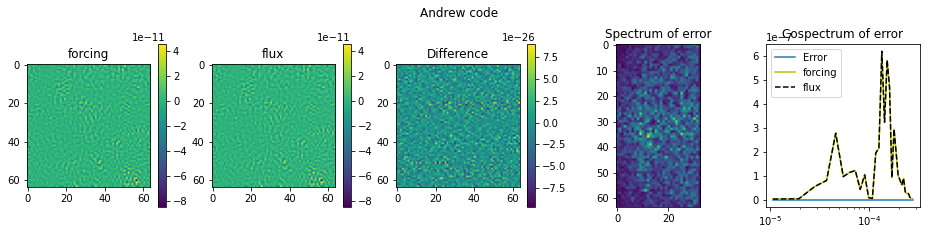

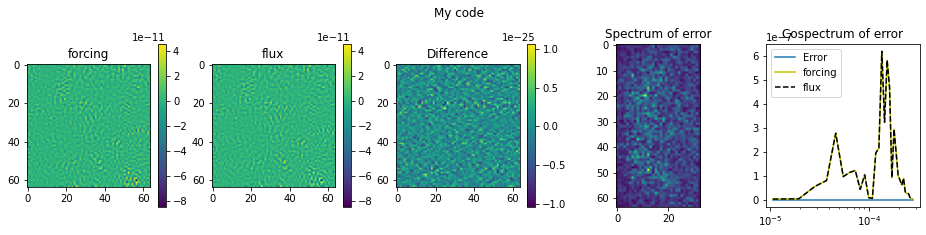

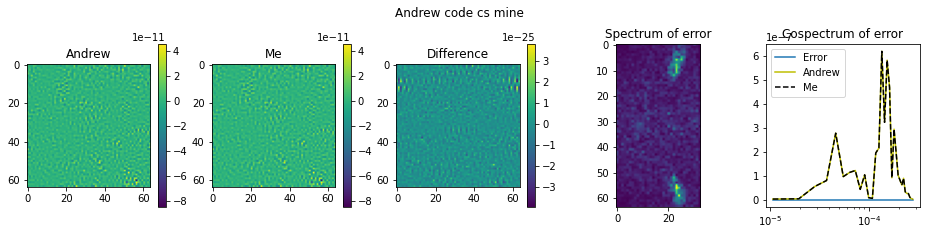

In [510]:
plot_commutation(ppb.Operator1, op.Operator1)

INFO:  Logger initialized


mean Andrew = 8.67746995743113e-30, mean Me = 3.944304526105059e-30


INFO:  Logger initialized


mean Andrew = -3.2343297114061484e-29, mean Me = -7.888609052210118e-31
mean Andrew = 3.944304526105059e-30, mean Me = -7.888609052210118e-31


INFO:  Logger initialized


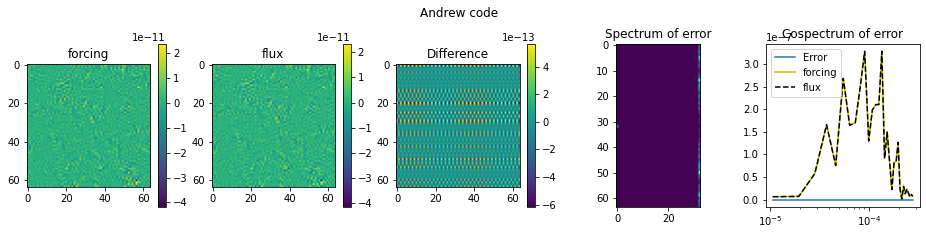

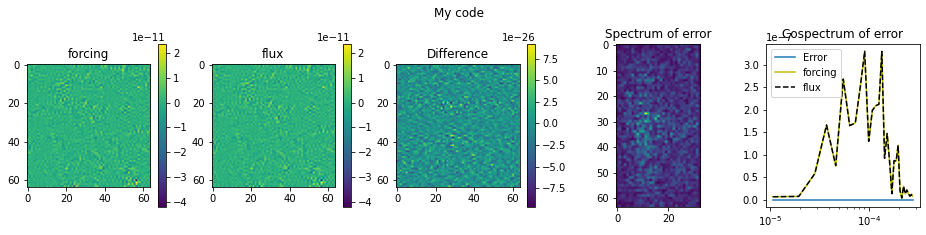

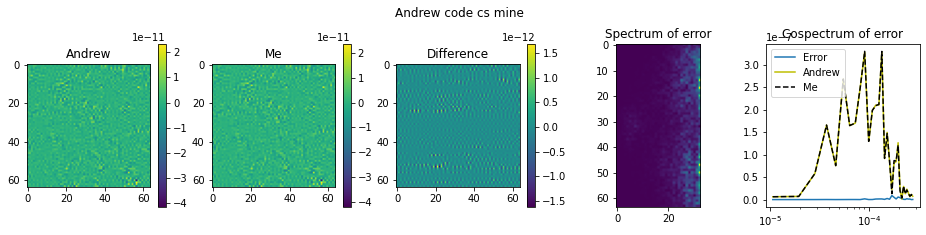

In [513]:
plot_commutation(ppb.Operator2, op.Operator2)

INFO:  Logger initialized


mean Andrew = -1.139904008044362e-28, mean Me = 1.9721522630525295e-29


INFO:  Logger initialized


mean Andrew = 1.8143800820083272e-29, mean Me = -3.865418435582958e-29


INFO:  Logger initialized


mean Andrew = 1.9721522630525295e-29, mean Me = -3.865418435582958e-29


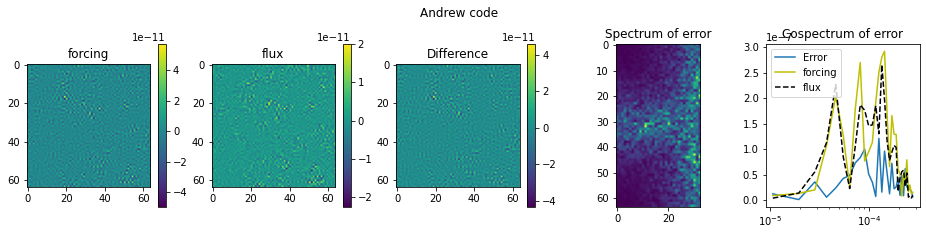

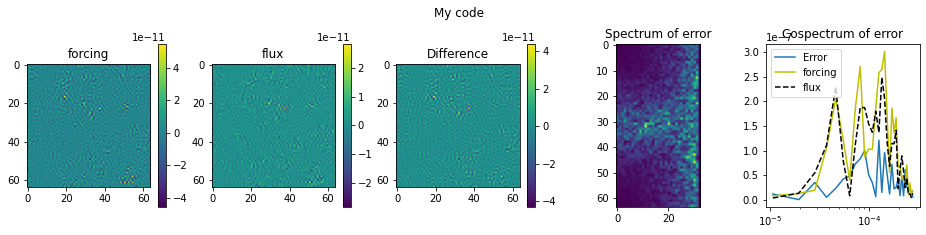

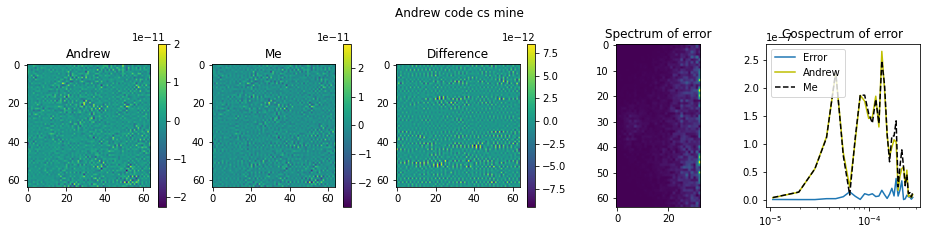

In [515]:
plot_commutation(ppb.Operator3, op.Operator3)

# Gaussian noise as initial condition

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


5.370810666279279e-07
-5.88217324482153e-24


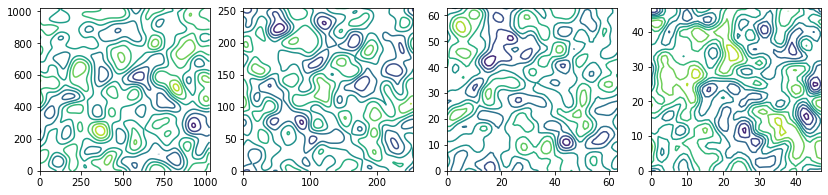

In [426]:
plt.figure(figsize=(14,3))
plt.subplot(1,4,1);plt.contour(pyqg.QGModel(nx=1024).gaussian_field())
plt.subplot(1,4,2);plt.contour(pyqg.QGModel(nx=256).gaussian_field())
plt.subplot(1,4,3);plt.contour(pyqg.QGModel(nx=64).gaussian_field())
plt.subplot(1,4,4);plt.contour(pyqg.QGModel(nx=48).gaussian_field())
print(pyqg.QGModel(nx=48).gaussian_field().std())
print(pyqg.QGModel(nx=48).gaussian_field().mean())

In [434]:
m = pyqg.QGModel(tmax=86400*360*10, twrite=10000)
ds = []
for t in m.run_with_snapshots(tsnapint=1000*3600):
    ds.append(m.to_dataset())
old_noise = xr.concat(ds, dim='time')

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 2.96e-04, CFL: 0.074
INFO: Step: 20000, Time: 1.44e+08, KE: 5.05e-04, CFL: 0.092
INFO: Step: 30000, Time: 2.16e+08, KE: 4.68e-04, CFL: 0.103
INFO: Step: 40000, Time: 2.88e+08, KE: 5.72e-04, CFL: 0.101


In [435]:
m = pyqg.QGModel(tmax=86400*360*10, twrite=10000)
m.set_q1q2(m.gaussian_field(), 0*m.x)
ds = []
for t in m.run_with_snapshots(tsnapint=1000*3600):
    ds.append(m.to_dataset())
new_noise = xr.concat(ds, dim='time')

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 2.25e-04, CFL: 0.073
INFO: Step: 20000, Time: 1.44e+08, KE: 5.36e-04, CFL: 0.098
INFO: Step: 30000, Time: 2.16e+08, KE: 4.68e-04, CFL: 0.095
INFO: Step: 40000, Time: 2.88e+08, KE: 5.05e-04, CFL: 0.112


In [436]:
def KE(dataset):
    return (op.ave_lev((dataset.u**2 + dataset.v**2)*0.5, 0.25)).mean(dim=('x','y'))

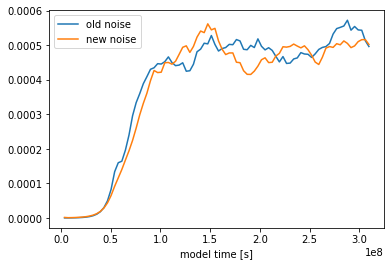

In [437]:
KE(old_noise).plot(label='old noise')
KE(new_noise).plot(label='new noise')
plt.legend()

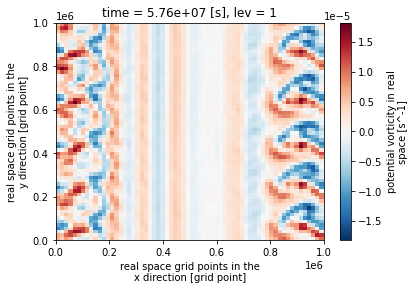

In [438]:
old_noise.q.isel(time=15, lev=0).plot()

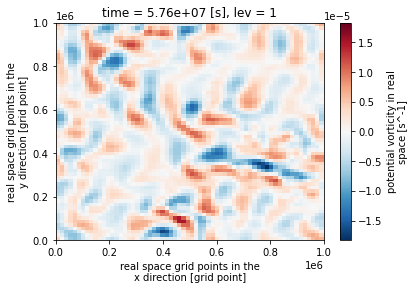

In [439]:
new_noise.q.isel(time=15,lev=0).plot()

In [456]:
m = pyqg.QGModel(tmax=86400*30)
m.q.mean(axis=(1,2))
for t in m.run_with_snapshots():
    print(m.q.mean(axis=(1,2)))

INFO:  Logger initialized


[3.30872245e-24 0.00000000e+00]
[3.30872245e-24 0.00000000e+00]
[-3.30872245e-24 -4.13590306e-25]
[3.30872245e-24 0.00000000e+00]
[ 0.00000000e+00 -8.27180613e-25]
[-3.30872245e-24  0.00000000e+00]
